In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

## Introductory demo on probability density

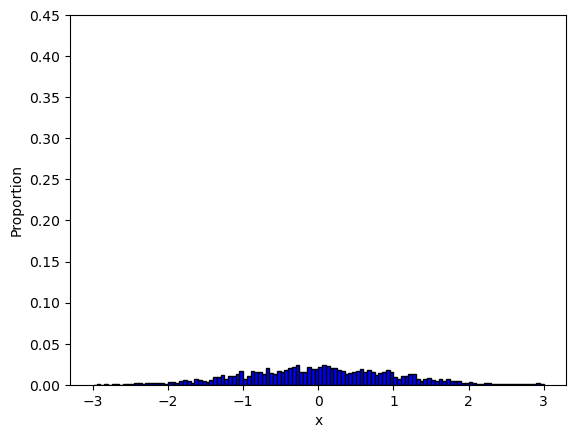

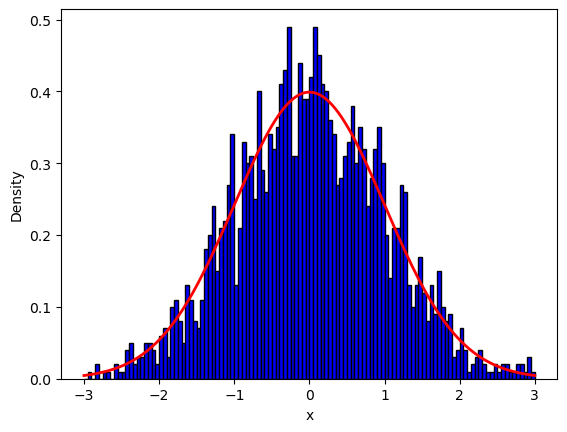

In [ ]:

n = 2000
X = np.random.normal(0, 1, n)


bin_width = 0.05
bins = np.arange(-3, 3 + bin_width, bin_width)

## plot the histogram
weights = np.ones(n) / n 
plt.hist(X, bins=bins, color='blue', 
         edgecolor='black', linewidth=1, 
         weights=weights)

plt.yticks(np.arange(0, 0.5, 0.05)) 
plt.xlabel('x')
plt.ylabel('Proportion')
plt.show()


## plot the discretized density
weights = weights/bin_width
plt.hist(X, bins=bins, color='blue', 
         edgecolor='black', linewidth=1, 
         weights=weights)

plt.xlabel('x')
plt.yticks(np.arange(0, 2, 0.1))
plt.ylabel('Density')

# overlay beta density
xs = np.linspace(-3, 3, 1000)  
pdf = norm.pdf(xs, 0, 1)
plt.plot(xs, pdf, color='red', linewidth=2)
plt.show()

## Example 2.1: simple example of Bayesian posterior

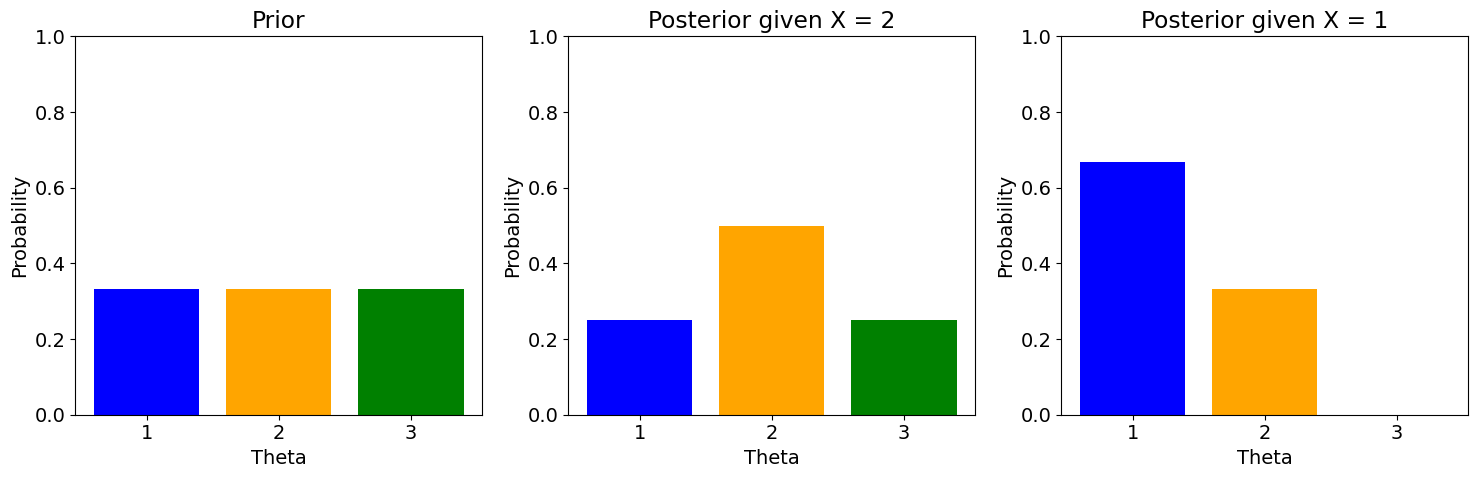

In [2]:
import matplotlib.pyplot as plt

distributions = {
    "Prior": [1/3, 1/3, 1/3],
    "Posterior given X = 2": [1/4, 1/2, 1/4],
    "Posterior given X = 1": [2/3, 1/3, 0]
}


plt.rcParams.update({'font.size': 14})
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, (title, probs) in enumerate(distributions.items()):
    axes[i].bar([1, 2, 3], probs, color=['blue', 'orange', 'green'])
    axes[i].set_title(title)
    axes[i].set_xticks([1, 2, 3])
    axes[i].set_ylim(0, 1)
    axes[i].set_xlabel('Theta')
    axes[i].set_ylabel('Probability')

plt.tight_layout()
plt.show()



## Example 2.2: posterior of binomial mean

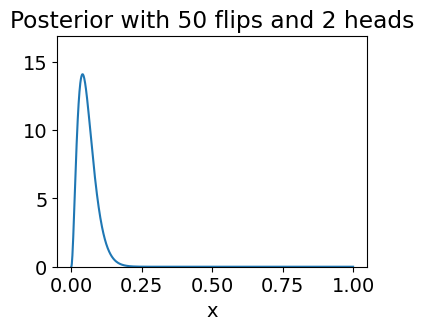

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta

n = 50
num_heads = 2

a = 1 + num_heads
b = 1 + n - num_heads

x = np.linspace(0, 1, 1000)
y = beta.pdf(x, a, b)

plt.figure(figsize=(4, 3))
plt.plot(x, y)
plt.title(f"Posterior with {n} flips and {num_heads} heads")
plt.xlabel('x')
plt.ylim(0, np.max([y.max() * 1.2, 7]))
plt.show()



### Additional example illustrating the notion of posterior

num instances with S = 8:  963


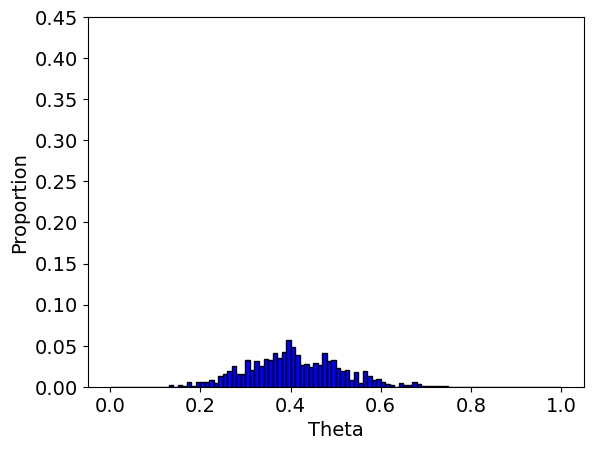

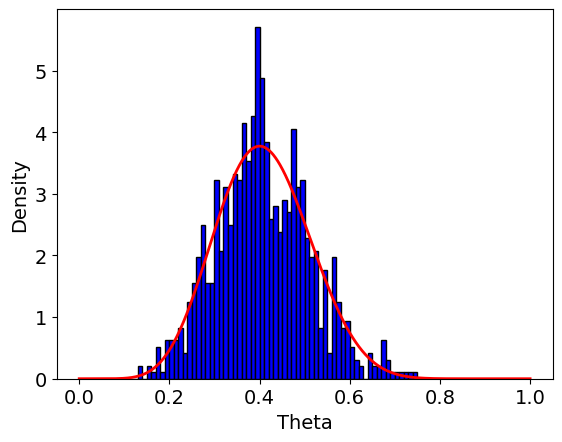

In [4]:
n_sim = 20000

m = 20

results = np.zeros((n_sim, 2))

for i in range(n_sim):
    theta = np.random.uniform(0, 1)
    S = np.random.binomial(m, theta)

    results[i, 0] = theta
    results[i, 1] = S


## simulated posterior given S = s
s = 8 
conditional_thetas = results[results[:, 1] == s, 0]
num_instances = conditional_thetas.shape[0]

print(f"num instances with S = {s}:  {num_instances}")

bin_width = 0.01
bins = np.arange(0, 1 + bin_width, bin_width)


## plot the histogram
weights = np.ones(num_instances) / num_instances 
plt.hist(conditional_thetas, bins=bins, color='blue', 
         edgecolor='black', linewidth=1, 
         weights=weights)

plt.yticks(np.arange(0, 0.5, 0.05)) 
plt.xlabel('Theta')
plt.ylabel('Proportion')
plt.show()


## plot the discretized density
weights = weights/bin_width
plt.hist(conditional_thetas, bins=bins, color='blue', 
         edgecolor='black', linewidth=1, 
         weights=weights)

plt.yticks(np.arange(0, 6, 1)) 
plt.xlabel('Theta')
plt.ylabel('Density')

# overlay beta density
x = np.linspace(0, 1, 1000)  
pdf = beta.pdf(x, a=s+1, b=m-s+1)
plt.plot(x, pdf, color='red', linewidth=2)

plt.show()




## Example 2.3: posterior simulation for the 2020 election

In [5]:
import pandas as pd
import numpy as np
from scipy.stats import beta

# Read the CSV file
polls = pd.read_csv("election_polls.csv")

n_state = len(polls)
n_sim = 3000

all_results = np.zeros(n_sim)

bias_adjustment = 0.03

for cur_sim in range(n_sim):
    all_thetas = np.zeros(n_state)
    for j in range(n_state):
        mu = polls.loc[j, "Percent Trump"] / 100 + bias_adjustment
        n = polls.loc[j, "Sample Size"]
        all_thetas[j] = beta.rvs(mu * n + 1, (1 - mu) * n + 1) 

    votes = (all_thetas > 0.5) * polls["Electors"]
    all_results[cur_sim] = sum(votes)

print(f"Proportion of simulations where Trump wins: {np.mean(all_results > 269)}")

plt.figure(figsize=(4, 3))
plt.hist(all_results, bins=range(50, 500, 10))
plt.axvline(270, color='black', linestyle='--')
plt.xlabel('Electoral votes for Trump')
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'election_polls.csv'

## Example 2.4: MCMC for posterior from pairwise comparison

In [ ]:
import pandas as pd
import numpy as np

# Load the data
games = pd.read_csv("nba2024.csv")
n_games = len(games)

# Get all team names
teams = pd.unique(games[['Winner', 'Loser']].values.ravel('K'))
n_teams = len(teams)

# Initialize ratings and all_ratings dictionaries
ratings = {team: np.random.choice([1, 2, 3]) for team in teams}
all_ratings = {team: [] for team in teams}


n_MCMC = 1100
n_Burn = 100
SAprob = 0.7
SBprob = 0.9
ABprob = 0.7
sameprob = 0.5

# MCMC Simulation
for j in range(n_MCMC):

    for cur_team in teams:
        weights = np.ones(3)
        
        for i in range(n_games):
            
            if cur_team not in [games.iloc[i, 0], games.iloc[i, 1]]:
                continue

            opponent = games.iloc[i, 1] if cur_team == games.iloc[i, 0] else games.iloc[i, 0]
            opponent_rating = ratings[opponent]
            
            ## if cur_team is the winner
            if cur_team == games.iloc[i, 0]:
                if opponent_rating == 1:
                    weights *= [sameprob, 1-SAprob, 1-SBprob]
                elif opponent_rating == 2:
                    weights *= [SAprob, sameprob, 1-ABprob]
                else:
                    weights *= [SBprob, ABprob, sameprob]
            else: # if cur_team is the loser
                if opponent_rating == 1:
                    weights *= [sameprob, SAprob, SBprob]
                elif opponent_rating == 2:
                    weights *= [1-SAprob, sameprob, ABprob]
                else:
                    weights *= [1-SBprob, 1-ABprob, sameprob]
        
        ratings[cur_team] = np.random.choice([1, 2, 3], p=weights/weights.sum())

    if j > n_Burn:
        all_ratings[cur_team].append(ratings[cur_team])



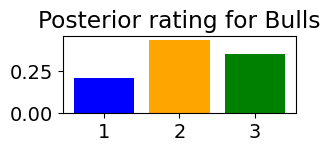

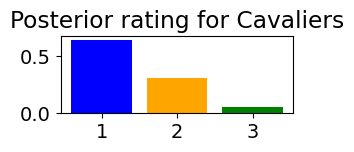

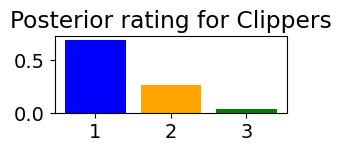

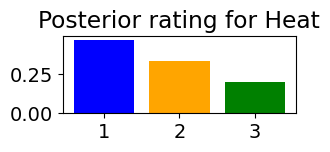

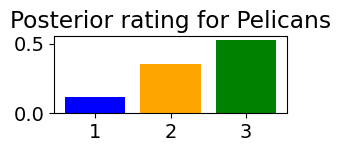

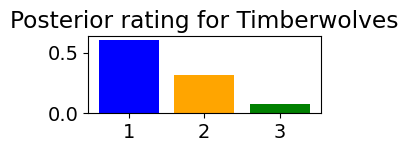

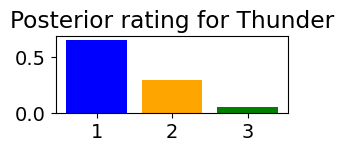

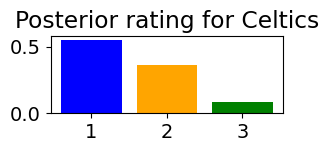

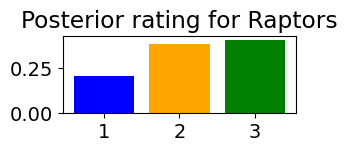

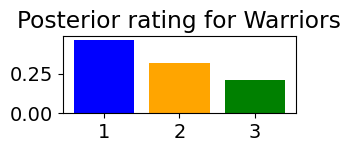

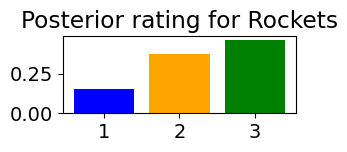

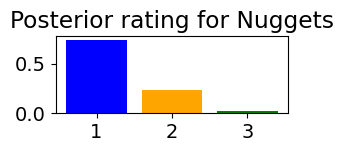

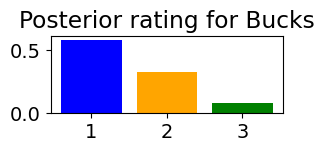

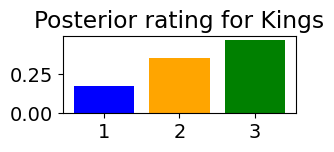

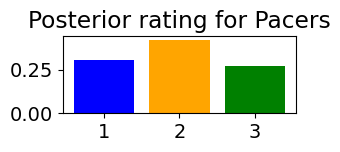

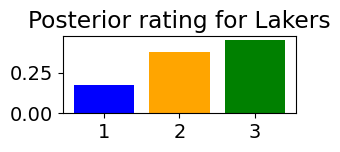

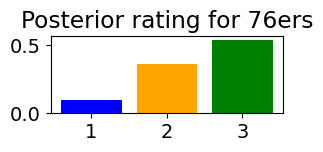

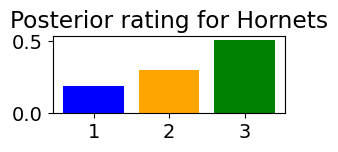

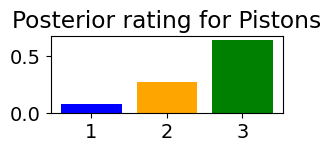

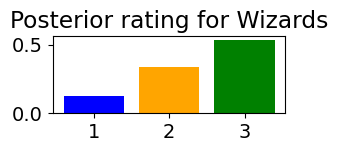

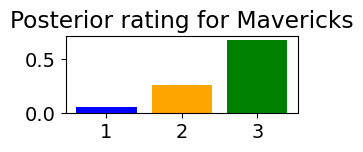

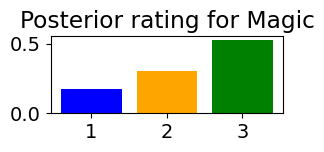

In [ ]:
# Printing the results
for cur_team in teams:

    cur_posterior = np.zeros(3)
    for j in range(3):
        cur_posterior[j] = np.mean(np.array(all_ratings[cur_team]) == j+1)

    ## create small plot
    plt.figure(figsize=(3, 1))
    plt.bar([1, 2, 3], cur_posterior, color=['blue', 'orange', 'green'])
    plt.title(f"Posterior rating for {cur_team}")
    plt.show()
